# Configure your Notebook with your Google drive

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import necessary  libraries

In [10]:
# Keras Imports
import random
from tensorflow.keras import models

import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from keras.preprocessing.image import load_img, img_to_array
from keras import backend as K
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
from tensorflow.keras.layers import GlobalAveragePooling2D
# Other imports
import matplotlib.pyplot as plt
import glob
import cv2
from keras.models import load_model

In [11]:
# load model
model = load_model("/content/drive/My Drive/malaria/model_64_64_3.h5")

In [12]:
# summarize model.
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 31, 31, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 32)        128       
_________________________________________________________________
f1 (Conv2D)                  (None, 12, 12, 32)       

# load files from google drive

In [13]:
files = glob.glob(r"/content/drive/My Drive/malaria/cell_images//Parasitized/*.png")

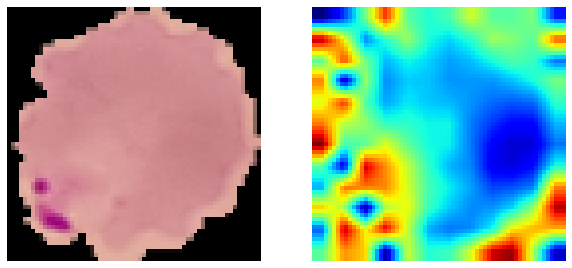

In [14]:
#create a random number
num = random.randint(0,1000)

# read a random image
img = cv2.imread(files[num])

# save the image local disk
plt.imsave(r"/content/sample_data/img.png",img)

# BGR2RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#Resizing it to (64,64,3)
img = cv2.resize(img,(64,64))

#Expand dims in axis = 0
img = np.expand_dims(img, axis=0)

# Generate prediction
pred = model.predict(img)

# Generate prediction class
pred_output = model.output[:, np.argmax(pred)]

# Feature map of 'f1' layer, which is the last convolution layer
last_conv_layer = model.get_layer('f1')

# create a functional model
last_conv_layer_model = Model(model.inputs, last_conv_layer.output)

# New model's input shape
classifier_input = Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input

# My model's classification layers (add layer names from last conv layer upto prediction layer)
classifier_layer_names = ["max_pooling2d_3",'batch_normalization_3','dropout_1','flatten_1',"dense_1","batch_normalization_4",'dropout_2']


for layer_name in classifier_layer_names:
    x = model.get_layer(layer_name)(x)

# Functional model creation
classifier_model = Model(classifier_input, x)

# Compute gradients
with tf.GradientTape() as tape:
    last_conv_layer_output = last_conv_layer_model(img)
    tape.watch(last_conv_layer_output)
    
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0])
    top_class_channel = preds[:, top_pred_index]
    
grads = tape.gradient(top_class_channel, last_conv_layer_output)
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

last_conv_layer_output = last_conv_layer_output.numpy()[0]
pooled_grads = pooled_grads.numpy()
for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output[:, :, i] *= pooled_grads[i]

#Calculate heat map
heatmap = np.mean(last_conv_layer_output, axis=-1)
heatmap = np.maximum(heatmap, 0)

    
heatmap = np.uint8(255*heatmap)

# apply jet color map
#heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
heatmap = cv2.resize(heatmap,(64,64))
heatmap = heatmap.reshape((64,64))


plt.figure(figsize = [10,10])
plt.subplot(1,2,1)
plt.imshow(img.reshape(64,64,3))
plt.axis("off");

plt.subplot(1,2,2)
plt.imshow(heatmap,cmap = 'jet')
plt.axis("off");